# SMCN finetuning simulation

In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import pandas as pd
from tqdm import tqdm

from ucn.models import SMCN
from src.trainer import SMCNTrainer
from src.dataset import ChunkDataset
from src.utils import plot_range, compute_cost, freq_filter

torch.manual_seed(28)

%load_ext autoreload
%autoreload 2

!rm -r lightning_logs/*

plt.rcParams.update({
    'font.size': 25,
    'figure.figsize': (25, 5)
})

## Generate noisy dataset from the model

In [2]:
d_in = 3
d_emb = 2
d_out = 1
N = 200

model = SMCN(d_in, d_emb, d_out, n_particles=1)

# Sets the range of a few parameters
model._f._linear.weight.data = torch.randn(d_out, d_emb) * 0.2 + 0.8
model._g.weight_hh.data = torch.randn(d_emb, d_emb) * 0.2
model._g.weight_ih.data = torch.randn(d_emb, d_in)*0.2 + 0.8
model._sigma_x.data = torch.eye(d_emb)*0.1
params_simulation = copy.deepcopy(model.state_dict())

The dataset is sampled from a model defined as
$$
\begin{equation*}
        \left\{
        \begin{aligned}
                x_{t+1} & = \tanh(W_{xx} x_{t} + W_{xu} u_{t+1} + b_x) + \eta_{t+1} \\
                y_{t+1} & = \tanh(W_y x_{t+1}^L + b_y) + \epsilon_{t+1}                        \\
        \end{aligned}
        \right.
\end{equation*}
$$

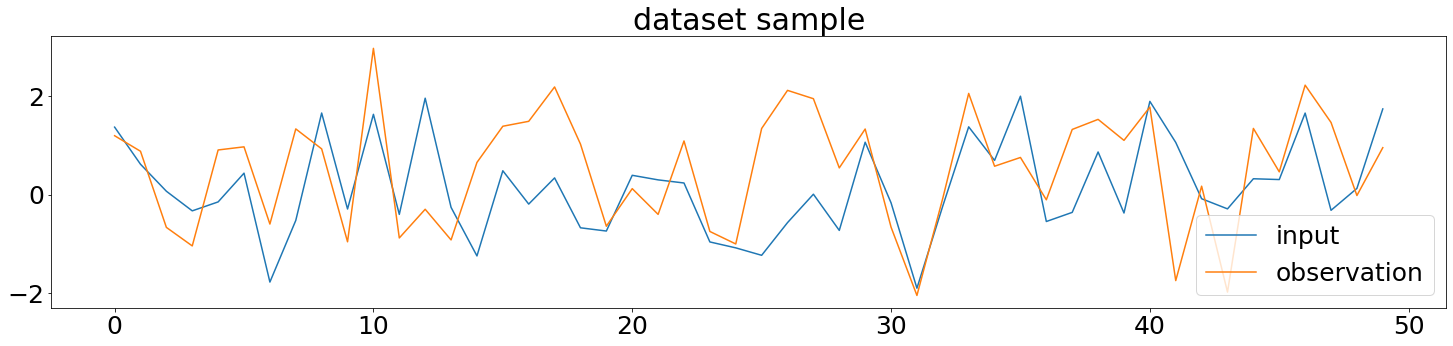

In [3]:
T = 50
n_samples = 100

sigma_y = 0.15

# Generate random inputs
u = torch.randn(T, n_samples, d_in)

# Compute outputs with added noise on the hidden state with variance sigma_x
with torch.no_grad():
    y = model(u, noise=True).view((T, n_samples, d_out))

# Add noise on the observations with variance sigma_y
y = y + torch.randn(y.shape) * np.sqrt(sigma_y)

# Display the value of sigma_y once data is normalized
# print(f'sigma_y_norm: {sigma_y / (y.max() - y.min()).item()**2:.3f}')

# Plot a random sample
idx = np.random.randint(n_samples)
plt.plot(u[:, idx, 0].numpy(), label='input')
plt.plot(y[:, idx, 0].numpy(), label='observation')
plt.title('dataset sample')
plt.legend()
plt.show()

In [4]:
batch_size = 4
epochs = 50

dataset = ChunkDataset(y=y.transpose(0, 1).numpy(),
                      u=u.transpose(0, 1).numpy())
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        num_workers=4,
                        shuffle=True
                       )

## Pretrain

In [5]:
# Initialize a new model with random weights
model = SMCN(d_in, d_emb, d_out, n_particles=1)

# Run training
train_model = SMCNTrainer(model, lr=1e-3)
trainer = pl.Trainer(max_epochs=epochs, gpus=1)
trainer.fit(train_model, dataloader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type | Params
--------------------------------
0 | _model | SMCN | 238   
--------------------------------
238       Trainable params
0         Non-trainable params
238       Total params


Epoch 49: 100%|██████████| 25/25 [00:01<00:00, 19.91it/s, loss=0.33, v_num=0] 


1

In [6]:
# Save pretrain parameters
params_pretrain = copy.deepcopy(model.state_dict())
print(f'Cost after pretrain: {compute_cost(model, dataloader).item():.4f}')

Cost after pretrain: 0.0836


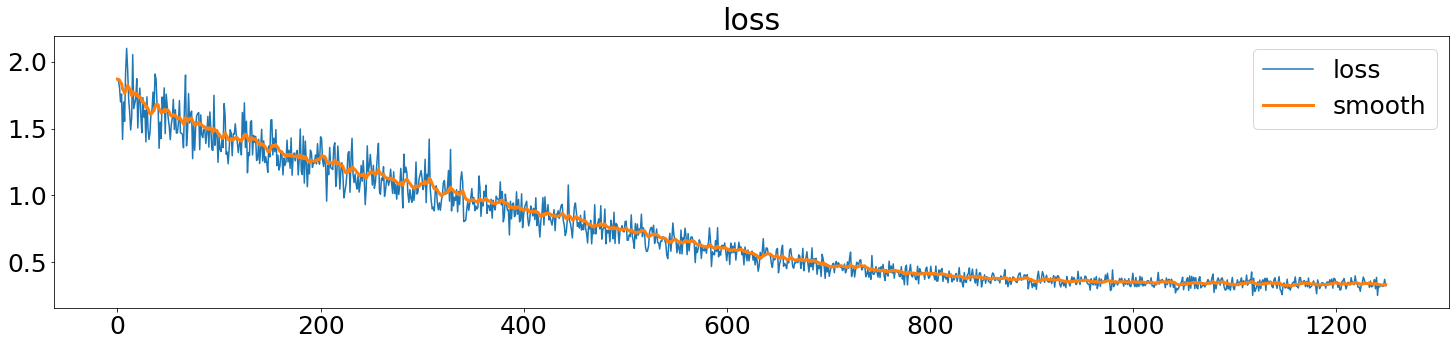

In [7]:
# Plot loss with each batch
plt.plot(train_model._hist['loss'], label='loss')
plt.plot(freq_filter(train_model._hist['loss'], alpha=0.9), lw=3, label='smooth')
plt.title('loss')
plt.legend()
plt.show()

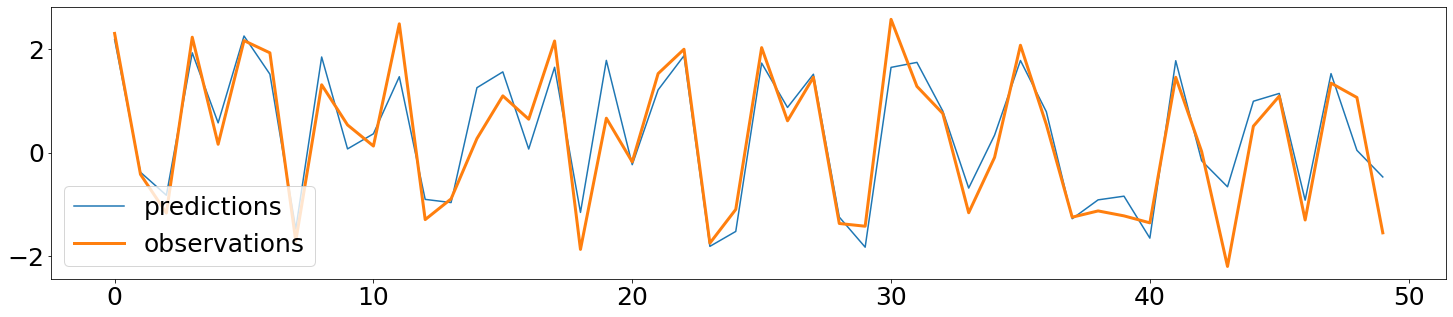

In [8]:
# Plot model predictions for a sample
for u, y in dataloader:
    u = u.transpose(0, 1)
    y = y.transpose(0, 1)
    break

with torch.no_grad():
    netout = model(u, noise=False)
    
netout = netout.numpy().squeeze()

plt.figure(figsize=(25, 5))
plt.plot(netout[:, 0], label='predictions')
plt.plot(y[:, 0, 0], lw=3, label='observations')
plt.legend()
plt.show()

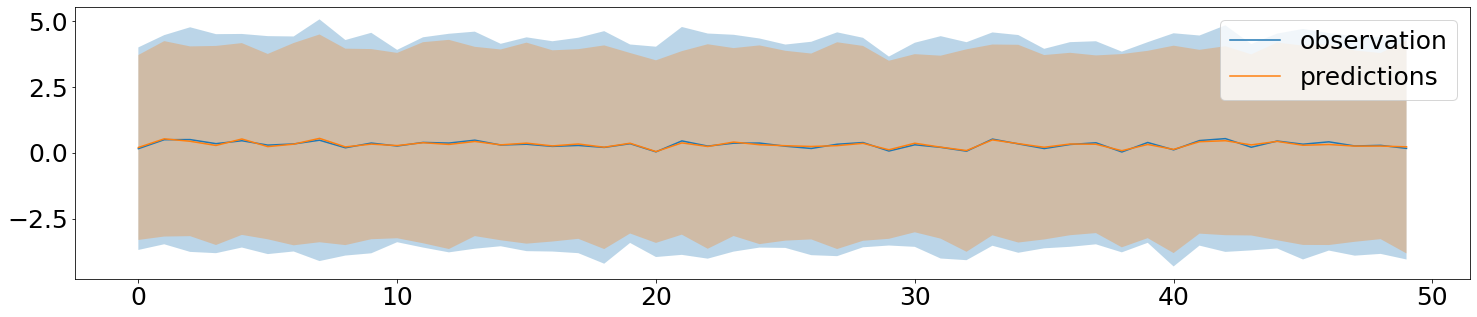

In [9]:
# Plot the mean and +/- 3 std of dataset and predictions of the dataset
y_hat = model(dataset._u.transpose(0, 1), noise=False).detach()

plot_range(dataset._y.numpy().squeeze().T, label='observation')
plot_range(y_hat.numpy().squeeze(), label='predictions')
plt.legend()
plt.show()

## Finetune

In [10]:
# Load pretrain parameters
model.load_state_dict(params_pretrain)
# model = SMCN(d_in, d_emb, d_out, n_particles=N)
# model.load_state_dict(params_simulation)

# Set the number of particules
model.N = N

# Freeze the model
for p in model.parameters():
    p.requires_grad = False

# Set sigma_x to a small value
model._sigma_x.data = torch.eye(d_emb)*0.1
# model._sigma_y.data = torch.log(torch.eye(1)*0.15)
# Allow gradient descent only for f and sigma_y
model._sigma_y.requires_grad = True

for p in model._f.parameters():
    p.requires_grad = True

In [11]:
# Train by maximizing log likelihood
train_model = SMCNTrainer(model, lr=1e-2)
trainer = pl.Trainer(max_epochs=20, gpus=0)
trainer.fit(train_model, dataloader)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/home/mrmojo/Code/these/uncertaintyQuantification/.env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name   | Type | Params
--------------------------------
0 | _model | SMCN | 238   
--------------------------------
4         Trainable params
234       Non-trainable params
238       Total params


Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  7.45it/s, loss=7.91, v_num=1]


1

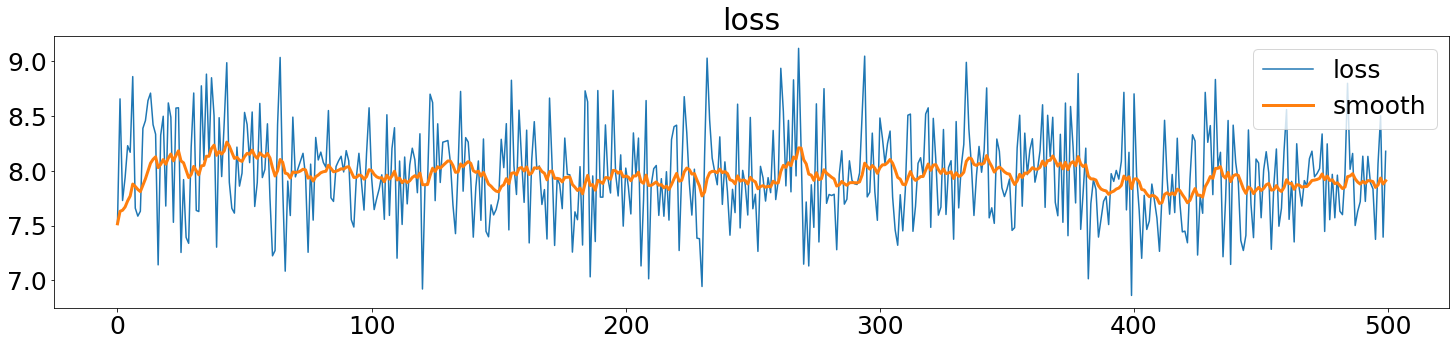

In [12]:
# Plot loss with each batch
plt.plot(train_model._hist['loss'], label='loss')
plt.plot(freq_filter(train_model._hist['loss'], alpha=0.9), lw=3, label='smooth')
plt.title('loss')
plt.legend()
plt.show()

In [13]:
# Check which parameters changed, and how much
for param_name, param in model.state_dict().items():
    diff = (param - params_pretrain[param_name]).abs().mean()
    if diff > 1e-5:
        print(param_name, '\n', diff, '\n')

_sigma_x 
 tensor(0.3004) 

_sigma_y 
 tensor(0.1969) 

_f._linear.weight 
 tensor(0.0274) 

_f._linear.bias 
 tensor(0.0318) 



In [14]:
model.sigma_x2

Parameter containing:
tensor([[0.1000, 0.0000],
        [0.0000, 0.1000]])

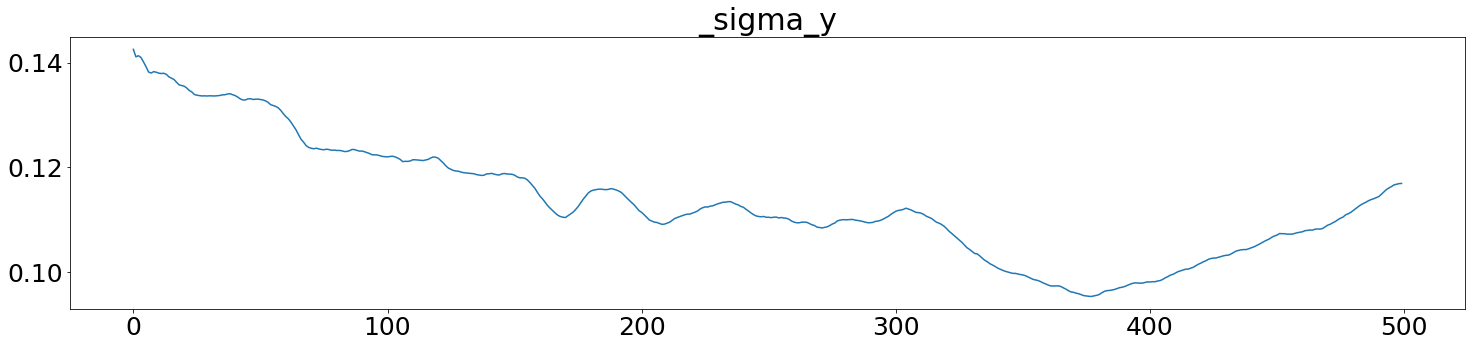

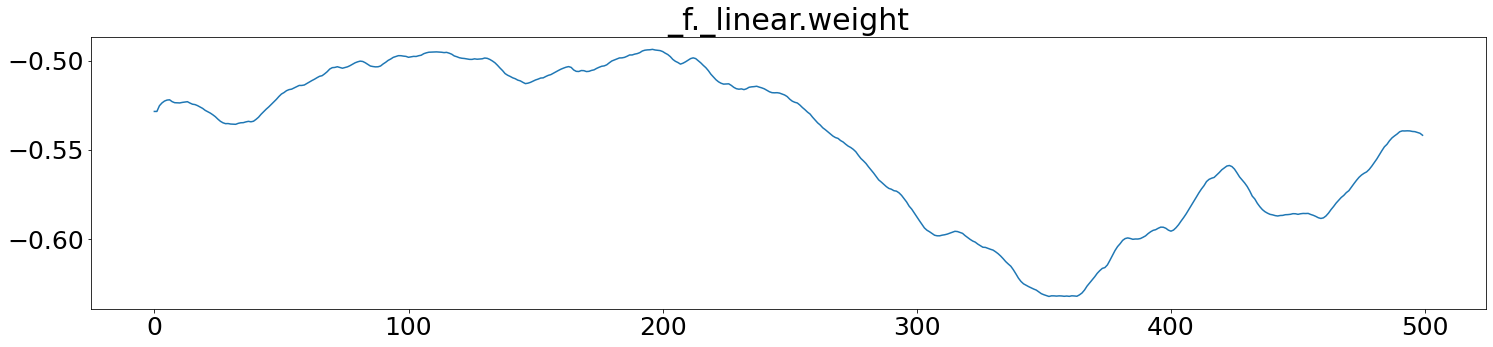

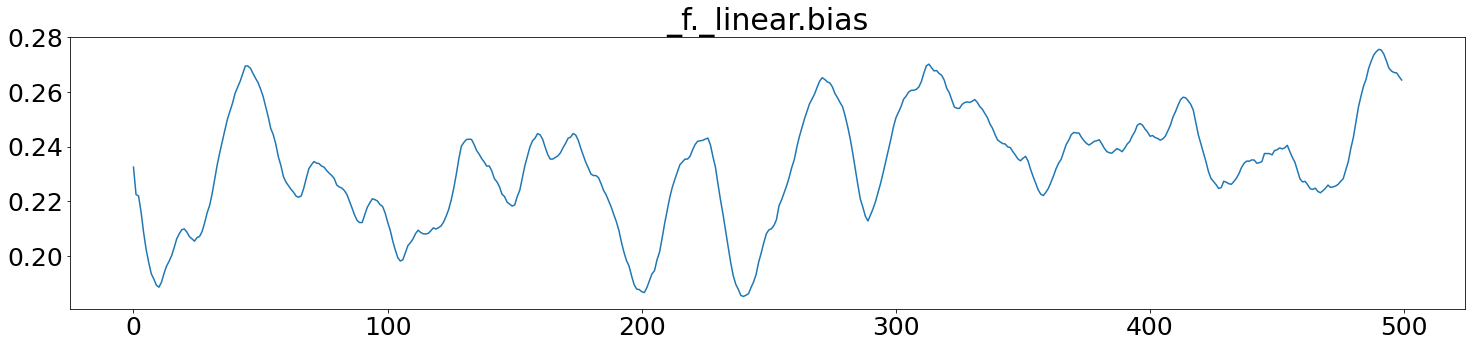

In [15]:
# Plot parameter evolutions
l = len(train_model._hist['_sigma_y'])

for param_name in model.state_dict().keys():
    if param_name.startswith('_input'):
        continue
    elif param_name in ['_sigma_y']:
        param_hist = np.exp(np.array(train_model._hist[param_name])).squeeze().reshape(l, -1).mean(-1)
    elif param_name in ['_sigma_x']:
        param_hist = torch.Tensor(train_model._hist[param_name]).squeeze().det().numpy()
    else:
        param_hist = np.array(train_model._hist[param_name]).squeeze().reshape(l, -1).mean(-1)
    if param_hist.std() < 1e-3:
        continue
    plt.figure()
    plt.plot(param_hist)
    plt.title(param_name)

In [16]:
print(f'Estimated sigma_y: {model.sigma_y2.item():.3f}')

Estimated sigma_y: 0.117


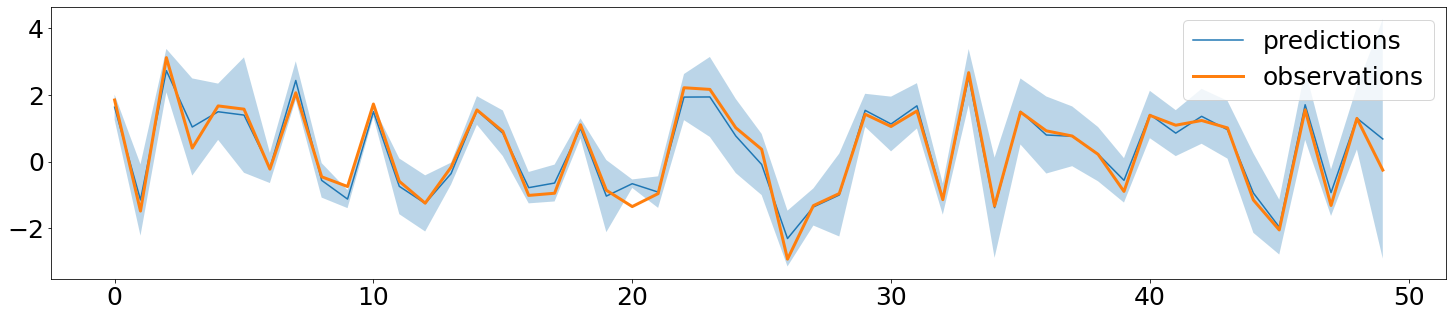

In [17]:
# Plot smoother's predictions
for u, y in dataloader:
    u = u.transpose(0, 1)
    y = y.transpose(0, 1)
    break

with torch.no_grad():
    netout = model(u=u,
                   y=y,
                   noise=True)

netout = model.smooth_pms(netout, model.I).numpy()

plt.figure(figsize=(25, 5))
plot_range(netout[:, 0, :, 0], label='predictions')
plt.plot(y[:, 0, 0], lw=3, label='observations')
plt.legend()

plt.show()

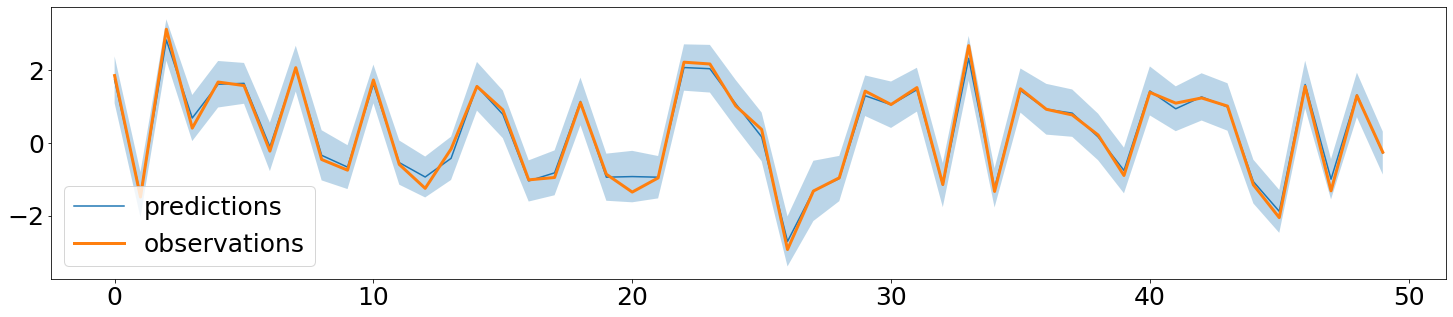

Accuracy: 100%


In [18]:
# Plot filter's prediction for each time step
with torch.no_grad():
    netout = model(u=u,
                   y=y,
                   noise=True)

netout = netout.squeeze()[:, 0]

# netout = netout + torch.randn(netout.shape) * np.sqrt(model.sigma_y.detach())-0.1
mean = netout * model.W[:, 0]
mean = mean.sum(-1)

std = netout.square() * model.W[:, 0]
std = std.sum(-1)
std = std + model.sigma_y2.detach().numpy() - np.square(mean)
std = std.flatten()

std = std.numpy()
mean = mean.numpy()

# plt.figure(figsize=(30, 8))
plt.plot(mean, label='predictions')
plt.fill_between(np.arange(len(mean)), mean - 3*std, mean + 3*std, alpha=.3)
# plt.fill_between(np.arange(len(mean)), mean - 3*std_wrong, mean + 3*std_wrong, alpha=.3)
plt.plot(y[:, 0, 0], lw=3, label='observations')
plt.legend()
plt.show()

accuracy = (((mean - 3*std) < y[:, 0, 0].numpy()) & (y[:, 0, 0].numpy() < (mean + 3*std))).sum() / mean.shape[0]
print(f'Accuracy: {accuracy*100:.0f}%')

In [19]:
def uncertainty_estimation(model, dataloader):
    accuracy = 0
    for u, y in tqdm(dataloader):
        u = u.transpose(0, 1)
        y = y.transpose(0, 1)

        with torch.no_grad():
            netout = model(u=u,
                           y=y,
                           noise=True)

        netout = netout.squeeze()
        y = y.squeeze()
        netout.shape

        mean = netout * model.W
        mean = mean.sum(-1)
        mean.shape

        std = netout.square() * model.W
        std = std.sum(-1)
        std = std + model.sigma_y2.detach() - mean.square()
        std.shape

        comparison = ((mean - 3*std) < y) & (y < (mean + 3*std))

        accuracy += comparison.to(dtype=float).mean()
    return accuracy / len(dataloader)

print(f"Uncertainty estimation: {uncertainty_estimation(model, dataloader):.3f}")

100%|██████████| 25/25 [00:02<00:00,  9.65it/s]

Uncertainty estimation: 0.993


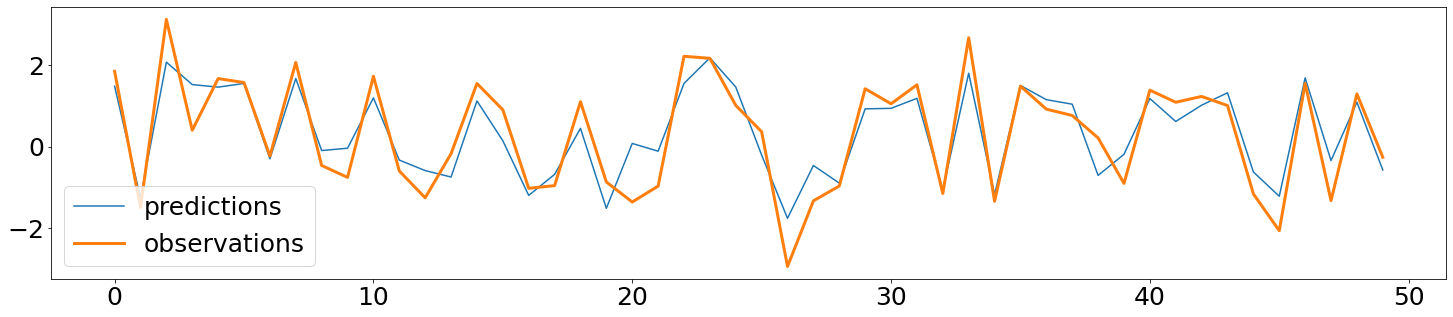

In [20]:
# Plot static model's predictions with adjusted weights
model.N = 1

with torch.no_grad():
    netout = model(u, noise=False)
    
netout = netout.numpy().squeeze()

plt.figure(figsize=(25, 5))
plt.plot(netout[:, 0], label='predictions')
plt.plot(y[:, 0, 0], lw=3, label='observations')
plt.legend()
plt.show()

In [21]:
print(f'Cost with adjusted weights: {compute_cost(model, dataloader).item():.4f}')

Cost with adjusted weights: 0.0840
